<a href="https://colab.research.google.com/github/BhagwatPriyanka/CE888/blob/main/Lab4/My_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import packages/libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Load the data files**

In [2]:
data=pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None)

In [3]:
test_data=pd.DataFrame(data)
test_data=pd.concat([test_data.loc[:, 0], test_data.loc[:, 1:].replace(99.00, np.NaN)], axis=1)
test_data.drop(columns=[0], inplace=True)

In [4]:
data=pd.concat([data.loc[:, 0], data.loc[:, 1:].replace(99.00, np.NaN)], axis=1)
data.drop(columns=[0], inplace=True)

In [5]:
val_data=pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None)
val_data.drop(columns=[0], inplace=True)
# val_data.head()

**Highest and lowest rated joke**

In [6]:
print('Joke with highest rating : ', test_data.max(axis=0).idxmax())
print('Joke with lowest rating : ', test_data.min(axis=0).idxmin())

Joke with highest rating :  45
Joke with lowest rating :  1


In [7]:
# val_data=pd.DataFrame(data)
# val_data.drop(columns=[0], inplace=True)

**Prepare Validation Data**

In [8]:
arr = val_data.values
arr.shape

(24983, 100)

In [9]:
rated = np.where(arr!=99)
print(len(rated[0]), rated[1].shape)

1810455 (1810455,)


In [10]:
# data.drop(columns=[0], inplace=True)

In [11]:
len(np.where(arr!=99)[1])

1810455

In [12]:
def replace(orig, percentage=0.1):
  """
  Replaces 'percentage'% of the original values in 'orig' with 99's
  :param orig: original data array
  :param percentage: percentage of values to replace (0<percentage<1)
  """
  new_data = orig.copy()
  rated = np.where(arr!=99)
  n_rated = len(rated[0])
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_data[rated[0][idx], rated[1][idx]] = 99
  return new_data, (rated[0][idx], rated[1][idx])

In [13]:
new_arr, idx = replace(arr, 0.1)

In [14]:
arr[idx[0][0], idx[1][0]]

-0.97

In [15]:
new_arr[idx[0][0], idx[1][0]]

99.0

In [16]:
val_data=pd.DataFrame(new_arr)
val_data=pd.DataFrame(val_data.loc[:, 0:].replace(99.00, np.NaN))
val_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,NaN,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,NaN,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,NaN,...,8.59,3.59,-6.84,-9.03,2.82,NaN,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,NaN,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,NaN,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,NaN,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,NaN,-5.0,2.77,8.3,7.77,7.33,6.21,NaN,8.98,8.64,8.20,3.93,4.85,4.85,NaN,8.98,4.51,-0.05,3.69,4.56,0.58,NaN,-4.95,-0.29,NaN,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,NaN,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,NaN,NaN,6.17,9.08,7.33,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,1.80,8.16,-2.82,NaN,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,-4.17,-5.39,NaN,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,NaN,4.61,8.06,-9.47,NaN,5.68,2.48,3.20,-1.26,NaN,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


**Training**

In [17]:
n_latent_factors = 2

user_ratings = data.values
# Initialise as random values
latent_user_preferences = np.random.random((user_ratings.shape[0], n_latent_factors))
latent_item_features = np.random.random((user_ratings.shape[1], n_latent_factors))

In [18]:
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)


def train(user_id, item_id, rating, alpha=0.0001):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err
    

def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = user_ratings[user_id, item_id]
                if not np.isnan(rating):
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 2) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

In [19]:
num_iter = 10
hist = sgd(num_iter)  # Note how the MSE decreases with the number of iterations

Iteration 0/10:	MSE=26.185535
Iteration 2/10:	MSE=24.962649
Iteration 4/10:	MSE=24.497031
Iteration 6/10:	MSE=24.024777
Iteration 8/10:	MSE=23.548050


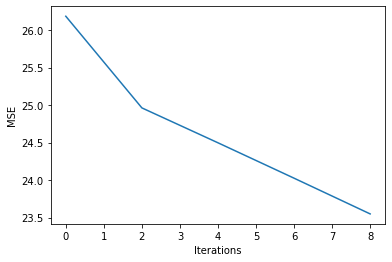

In [20]:
plt.figure()
plt.plot(np.arange(0, num_iter, 2), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

**Predicting**

In [21]:
predictions = latent_user_preferences.dot(latent_item_features.T)
predictions

array([[1.2639094 , 0.80078372, 0.77455417, ..., 1.47997918, 0.5729326 ,
        1.99781539],
       [1.27637203, 0.84418862, 0.92062192, ..., 1.53695239, 0.6880019 ,
        2.02789894],
       [2.17403024, 1.39935772, 1.41784048, ..., 2.57187692, 1.05310764,
        3.44282707],
       ...,
       [0.91126561, 0.58468591, 0.58701798, ..., 1.07579705, 0.43566308,
        1.44254759],
       [1.06196762, 0.67667834, 0.66577051, ..., 1.24809811, 0.49322568,
        1.67973646],
       [1.34210585, 0.89197367, 0.98483255, ..., 1.62124893, 0.73671215,
        2.1335969 ]])

**Predicting on Validation set**

In [22]:
val_data=pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None)
val_data.drop(columns=[0], inplace=True)
val_data=pd.DataFrame(val_data.loc[:, 0:].replace(99.00, np.NaN))

v_data=pd.DataFrame(new_arr)
v_data=pd.DataFrame(v_data.loc[:, 0:].replace(99.00, np.NaN))

v_user_ratings=v_data.values

v_values = [zip(v_user_ratings[i], predictions[i]) for i in range(predictions.shape[0])]
v_comparison_data = pd.DataFrame(v_values)
v_comparison_data.columns = data.columns

# v_comparison_data

In [23]:
val_user_ratings=val_data.values

error = []

for user_id in range(latent_user_preferences.shape[0]):
    for item_id in range(latent_item_features.shape[0]):
        rating = val_user_ratings[user_id, item_id]
        
        if not np.isnan(rating):
             val_predicted_rating = predict_rating(user_id, item_id)
             err =  val_predicted_rating - rating
             
            #  err = train(user_id, item_id, rating)
             error.append(err)
val_mse = (np.array(error) ** 2).mean()
print('MSE on Validation Set :', val_mse)

MSE on Validation Set : 23.182042837703833


**Predicting on Test Set**

In [24]:
test_user_ratings=test_data.values
values = [zip(test_user_ratings[i], predictions[i]) for i in range(predictions.shape[0])]
comparison_data = pd.DataFrame(values)
comparison_data.columns = data.columns
comparison_data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,"(-7.82, 1.2639093993837136)","(8.79, 0.8007837183019868)","(-9.66, 0.7745541746273753)","(-8.16, -0.851745789295036)","(-7.52, 0.8717970368974359)","(-8.5, 2.222693940105467)","(-9.85, 0.034392535502181736)","(4.17, -0.36658021496450605)","(-8.98, -0.022602492197374625)","(-4.76, 1.6421561081634184)","(-8.5, 2.3224992800072894)","(-6.75, 2.2001597823409518)","(-7.18, -1.4082711846989182)","(8.45, 2.186062960778664)","(-7.18, -1.4367206297277897)","(-7.52, -2.8253714012933644)","(-7.43, -0.6786083064441558)","(-9.81, -0.2685394351406745)","(-9.85, 0.6812833586615763)","(-9.85, -0.41205286007986375)","(-9.37, 2.7949540992480477)","(1.5, 1.5395907773155686)","(-4.37, 0.6800513429554691)","(-9.81, -1.1387397230091958)","(-8.5, 1.056935543788873)","(1.12, 2.0501531578360903)","(7.82, 3.6499363029606435)","(2.86, 2.1307961753805316)","(9.13, 3.5049064756022785)","(-7.43, 0.24322529207123264)","(2.14, 2.8576378327595964)","(-4.08, 3.716074844371944)","(-9.08, -0.680665258719961)","(7.82, 1.6441492076058208)","(5.05, 3.5155123488460536)","(4.95, 3.720084459430664)","(-9.17, -0.8920476188548901)","(-8.4, 1.846058595193524)","(-8.4, 1.855896908406903)","(-8.4, 1.7373803818017286)",...,"(8.59, 3.119490280699154)","(3.59, 3.543791471503862)","(-6.84, 0.8993160169858285)","(-9.03, -0.16224767511946045)","(2.82, 2.8961552775967547)","(-1.36, 3.1166895355968727)","(-9.08, -0.32374448674453055)","(8.3, 3.2169219691786948)","(5.68, 3.200112218607369)","(-4.81, 1.109583309832688)","(nan, -0.047119390720565174)","(nan, 3.2277572090394213)","(nan, 1.7447779593480675)","(nan, -0.723154893521708)","(nan, 0.4275834987635115)","(nan, 2.9902337743841327)","(nan, 1.3828608424858484)","(-9.42, 2.3723508751394258)","(nan, 0.921347507241195)","(nan, 1.9864631293832888)","(nan, 2.37142229092146)","(-7.72, 1.5454178204819065)","(nan, 2.6170356323866986)","(nan, 1.2986015332733112)","(nan, 1.5770457742788584)","(nan, 0.7033715712140027)","(nan, 2.3464274120245827)","(nan, 2.59525065439029)","(nan, 3.988095463889205)","(nan, 1.2305647081647406)","(2.82, 2.554989055560851)","(nan, 1.8685640432462696)","(nan, 2.9980422178686683)","(nan, 1.5642311499672412)","(nan, 1.5241142594422692)","(nan, 1.9536263952557826)","(-5.63, 2.0970085172826223)","(nan, 1.4799791786053726)","(nan, 0.5729326039381737)","(nan, 1.9978153898050923)"
1,"(4.08, 1.2763720297143581)","(-0.29, 0.8441886223596333)","(6.36, 0.9206219219942683)","(4.37, -0.6064491492642544)","(-2.38, 0.830754601776121)","(-9.66, 2.1720810950550886)","(-0.73, -0.011537933106961568)","(-5.34, -0.3327061712644146)","(8.88, -0.060295266277365284)","(9.22, 1.5963278983628346)","(6.75, 2.376930176322975)","(8.64, 2.1444075757243977)","(4.42, -1.402633910908755)","(7.43, 2.1066258946337926)","(4.56, -1.5210382967495133)","(-0.97, -2.740895404205471)","(4.66, -0.6410426391605432)","(-0.68, -0.39133344767631356)","(3.3, 0.5422402297137665)","(-1.21, -0.3917474275018022)","(0.87, 2.738806562501123)","(8.64, 1.4569460020852107)","(8.35, 0.6588139324096858)","(9.17, -1.0841785455483441)","(0.05, 1.0779618668656006)","(7.57, 1.970507613013479)","(4.71, 3.6172792805296363)","(0.87, 2.1053831097240296)","(-0.39, 3.3533294511548872)","(6.99, 0.3266083938367233)","(6.5, 2.777180956706608)","(-0.92, 3.5038820831934165)","(7.14, -0.5973387874225069)","(9.03, 1.5968885317078931)","(-1.8, 3.493476508164245)","(0.73, 3.6223214346743484)","(7.09, -0.7451528243053473)","(3.4, 1.717753519056693)","(-0.87, 1.782879620404001)","(7.91, 1.6477949279461588)",...,"(-6.7, 3.010159527624125)","(-3.35, 3.3481362823967373)","(-9.03, 0.9297970243089552)","(4.47, -0.03418624310815807)","(4.08, 2.964338434222237)","(-3.83, 3.06421924822855)","(8.74, -0.21300516636089065)","(1.12, 3.0716839400604394)","(0.78, 3.13

In [25]:
# while 1: pass

# For Quiz

In [26]:
quiz_users = pd.read_excel("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/movies_latent_factors.xlsx",sheet_name='Users')
quiz_items = pd.read_excel("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/movies_latent_factors.xlsx",sheet_name='Items')

In [27]:
#quiz_movies

In [28]:
test_data.loc[11740 , 61]

-1.84

In [58]:
comparison_data.loc[11740, 61]

(-1.84, 2.48888761459081)

In [30]:
comparison_data.loc[23437, 58]

(nan, -1.8301863466298582)

In [31]:
quiz_users.loc[quiz_users['User']==4327, 'Factor14']

21   -0.09349
Name: Factor14, dtype: float64

In [32]:
round(-0.09349, 3)

-0.093

In [59]:
quiz_items.loc[quiz_items['Movie ID']==11, 'Factor3']

0    2.027269
Name: Factor3, dtype: float64

In [61]:
(quiz_items.loc[quiz_items['Factor10']==np.max(quiz_items['Factor10']), ['Movie ID', 'Factor10']])

,Movie ID,Factor10
65,808,1.546593


In [62]:
quiz_items.head()

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,11,Star Wars: Episode IV - A New Hope (1977),-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806
1,12,Finding Nemo (2003),-0.342185,-0.296586,-0.385962,2.443297,-1.097015,-0.619465,0.572887,0.329516,-0.712228,0.323554,-0.561948,-0.142405,-0.564415,0.506876,1.274993
2,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
3,14,American Beauty (1999),-0.634531,2.186059,-0.066681,0.086197,0.517558,-0.185319,-0.412352,0.063841,0.075937,-0.577682,0.526803,-1.465557,-0.819682,0.549010,-0.681191
4,22,Pirates of the Caribbean: The Curse of the Bla...,0.517348,-1.456763,0.369161,0.073903,-0.098332,-0.594722,0.828888,0.033626,-0.707414,0.717877,1.394326,-0.786986,1.429191,0.855746,-2.292566


In [63]:
np.argmin(quiz_items.loc[:, 'Factor10'].values)

47

In [64]:
quiz_items.loc[47, ['Title', 'Factor10']]

Title       Titanic (1997)
Factor10          -2.98681
Name: 47, dtype: object

In [73]:
a=quiz_items.loc[quiz_items['Movie ID']==862]

In [74]:
a=a.values.squeeze()

In [75]:
a=a[2:]
a

array([-0.5727828855904948, -0.0885460119956924, -0.0393095514549324,
       2.5392590669713613, -1.6911653095091341, -0.14001009282703283,
       0.9443313165937158, 0.5731837555208938, -0.3413665369069682,
       0.4767087774822856, -0.592486983176339, -0.1326580135010477,
       -0.7227065920938089, 0.25034072929439805, 0.9786269347844],
      dtype=object)

In [76]:
b=quiz_users.loc[quiz_users['User']==4997]

In [77]:
b=b.values.squeeze()

In [78]:
b=b[1:]
b

array([-0.18544338, -0.27649645, -0.78127547, -0.24050617,  0.02961055,
       -0.27181376, -0.0562656 , -0.1118247 , -0.29090984, -0.25508709,
       -0.09807896,  0.10311568, -0.10056309,  0.1001642 ,  0.04319591])

In [79]:
quiz_pred=np.dot(b, a.T)

In [80]:
round(quiz_pred, 2)

-0.42

In [46]:
c=quiz_items.loc[quiz_items['Movie ID']==812]
c=c.values.squeeze()
c=c[2:]
c

array([0.9444072873203204, -0.17405053859224534, 0.12318628233184109,
       2.2243105344641236, -0.5695513857263874, 0.018065057433469225,
       0.3010679396871695, 0.03472533646290326, -0.20630092072921338,
       0.5333225541299694, -0.8823041399125704, -0.4469824426741521,
       1.3020155376267466, 0.8368295247444454, -0.46760653696757254],
      dtype=object)

In [47]:
quiz_pred=np.dot(b, c.T)
round(quiz_pred, 2)

-0.22

In [88]:
u_2067=quiz_users.loc[quiz_users['User']==4768]
u_2067=u_2067.values.squeeze()
u_2067=u_2067[1:]
u_2067

array([-0.20402409,  0.16107871, -0.0904475 ,  0.13849453, -0.16293366,
        0.1638944 ,  0.05150182, -0.08858222,  0.126829  ,  0.06596709,
        0.08500812,  0.35540448,  0.007108  , -0.1186634 , -0.03912536])

In [89]:
all_item_factors=quiz_items.values[:, 2:]

In [90]:
quiz_ratings=np.dot(u_2067, all_item_factors.T)

In [91]:
np.argmax(quiz_ratings)

9

In [92]:
np.argsort(quiz_ratings)[::-1][:2]

array([ 9, 11])

In [93]:
quiz_items.loc[np.argsort(quiz_ratings)[::-1][:2], :]

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
9,85,Raiders of the Lost Ark (Indiana Jones and the...,-1.241724,0.021130,0.489161,0.424584,-1.262253,1.190654,-0.606434,0.305721,1.438862,0.402682,0.438831,0.784948,-0.874375,-0.399984,-0.197686
11,105,Back to the Future (1985),-1.107666,-0.039506,0.109809,0.169149,-1.625467,1.673495,-0.544459,0.420603,1.184404,0.396530,1.240446,0.016825,-0.582166,-0.757412,0.118024


In [54]:
u_4940=quiz_users.loc[quiz_users['User']==4373]
u_4940=u_4940.values.squeeze()
u_4940=u_4940[1:]
u_4940

array([-0.1365496 , -0.08940568, -0.23539942,  0.12058533, -0.16816781,
        0.12998995, -0.03508359, -0.32402785,  0.08753111,  0.04528984,
        0.20784991, -0.02897165, -0.1751839 , -0.05828269,  0.14779738])

In [55]:
quiz_ratings=np.dot(u_2067, all_item_factors.T)
np.argsort(quiz_ratings)[::-1][:2]

array([50, 11])

In [56]:
quiz_items.loc[np.argsort(quiz_ratings)[::-1][:2], :]

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
50,603,The Matrix (1999),-3.063639,-1.319283,-0.043618,-0.994612,-0.954054,0.190838,0.197918,-0.093962,-1.082840,-0.003843,1.377453,-1.668189,-1.348377,0.223797,0.752413
11,105,Back to the Future (1985),-1.107666,-0.039506,0.109809,0.169149,-1.625467,1.673495,-0.544459,0.420603,1.184404,0.396530,1.240446,0.016825,-0.582166,-0.757412,0.118024


In [57]:
np.average(data.loc[:, 45].values[~np.isnan(data.loc[:, 45].values)])

1.1086161781946073